<a href="https://colab.research.google.com/github/IosiaLectus/MLReadingGroup/blob/main/Copy_of_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2020/05/03<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Create a sampling layer

In [2]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [36]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(32, 32, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 16, 16, 32)   320         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 8, 8, 64)     18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 4, 4, 64)     36928       conv2d_6[0][0]                   
____________________________________________________________________________________________

## Build the decoder

In [37]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(4 * 4 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((4, 4, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              3072      
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 8, 8, 64)          36928     
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_transpose_13 (Conv2DT (None, 32, 32, 32)        18464     
_________________________________________________________________
conv2d_transpose_14 (Conv2DT (None, 32, 32, 1)         289 

## Define the VAE as a `Model` with a custom `train_step`

In [38]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

NameError: name 'mnist' is not defined

In [39]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255
mnist_digits.shape

(70000, 28, 28, 1)

In [40]:
mnist_digits_shape = list(mnist_digits.shape)
print(mnist_digits_shape)
mnist_digits_shape[1] = mnist_digits_shape[1] + 4
mnist_digits_shape[2] = mnist_digits_shape[2] + 4

pad_mnist_digits = np.zeros(tuple(mnist_digits_shape))
print(pad_mnist_digits.shape)
print(pad_mnist_digits[:,2:-2,2:-2,:].shape)
pad_mnist_digits[:,2:-2,2:-2,:] = mnist_digits
print(pad_mnist_digits.shape)

[70000, 28, 28, 1]
(70000, 32, 32, 1)
(70000, 28, 28, 1)
(70000, 32, 32, 1)


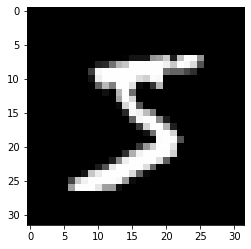

In [41]:
plt.imshow(pad_mnist_digits[0].reshape(pad_mnist_digits.shape[1], pad_mnist_digits.shape[2]), cmap="Greys_r")

In [43]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(pad_mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 6s 10ms/step - loss: 284.6798 - reconstruction_loss: 209.9179 - kl_loss: 2.7037
Epoch 2/30
547/547 [==============================] - 5s 10ms/step - loss: 166.2313 - reconstruction_loss: 158.5482 - kl_loss: 5.1495
Epoch 3/30
547/547 [==============================] - 5s 10ms/step - loss: 158.8681 - reconstruction_loss: 152.5914 - kl_loss: 5.5764
Epoch 4/30
547/547 [==============================] - 5s 10ms/step - loss: 155.9567 - reconstruction_loss: 149.7561 - kl_loss: 5.7404
Epoch 5/30
547/547 [==============================] - 5s 10ms/step - loss: 153.7827 - reconstruction_loss: 147.8672 - kl_loss: 5.8549
Epoch 6/30
547/547 [==============================] - 5s 10ms/step - loss: 152.7314 - reconstruction_loss: 146.4582 - kl_loss: 5.9469
Epoch 7/30
547/547 [==============================] - 5s 10ms/step - loss: 151.4778 - reconstruction_loss: 145.1900 - kl_loss: 6.0290
Epoch 8/30
547/547 [==============================] - 5s 10ms/

## Display a grid of sampled digits

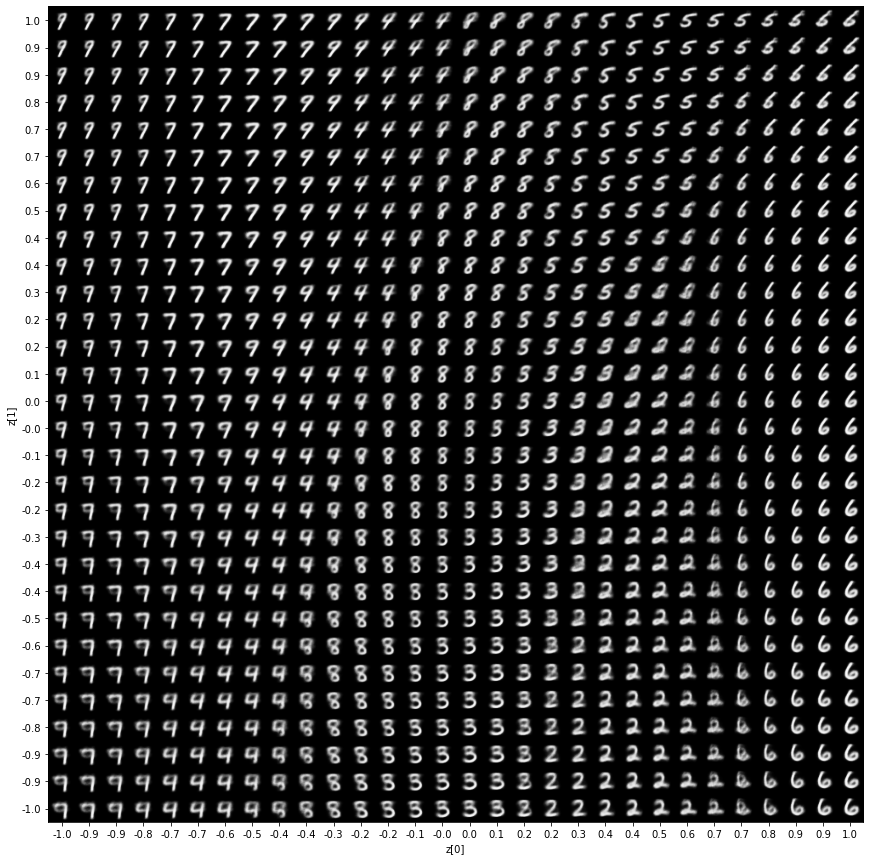

In [45]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 32
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

In [47]:
x_train.shape

(60000, 28, 28, 1)

## Display how the latent space clusters different digit classes

[60000, 28, 28, 1]
(60000, 32, 32, 1)
(60000, 28, 28, 1)
(60000, 32, 32, 1)


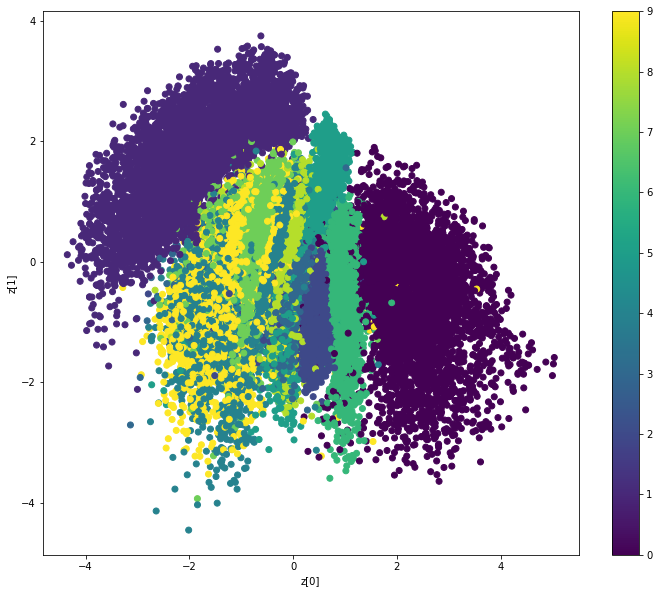

In [49]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_train_shape = list(x_train.shape)
print(x_train_shape)
x_train_shape[1] = x_train_shape[1] + 4
x_train_shape[2] = x_train_shape[2] + 4

pad_x_train = np.zeros(tuple(x_train_shape))
print(pad_x_train.shape)
print(pad_x_train[:,2:-2,2:-2,:].shape)
pad_x_train[:,2:-2,2:-2,:] = x_train
print(pad_x_train.shape)

plot_label_clusters(vae, pad_x_train, y_train)

0.5893692


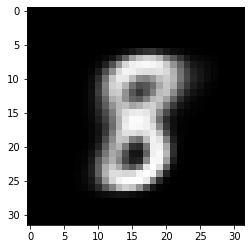

In [50]:
digit_size = 32
z_sample = np.array([[0, 0]])
x_decoded = vae.decoder.predict(z_sample)
digit = x_decoded[0].reshape(digit_size, digit_size)
plt.imshow(digit, cmap="Greys_r")
print(digit[10,20])

In [51]:
mnist_digits[0:1].shape

(1, 28, 28, 1)

[array([[-0.06382917, -0.2820692 ]], dtype=float32), array([[-8.750016 , -6.8099933]], dtype=float32), array([[-0.07353852, -0.24469167]], dtype=float32)]


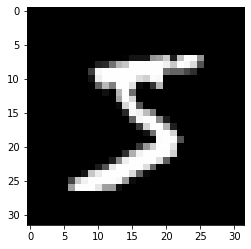

In [53]:
plt.imshow(pad_mnist_digits[0].reshape(digit_size, digit_size), cmap="Greys_r")
print(vae.encoder.predict(mnist_digits[0:1]))

In [54]:
print(vae.encoder.predict(pad_mnist_digits[0:1]))

[array([[0.19987956, 0.09837868]], dtype=float32), array([[-8.445417 , -6.7457223]], dtype=float32), array([[0.1876398 , 0.09963766]], dtype=float32)]
